In [ ]:
# multivariate Laplace prior with different rates?
# numpyro sampler?

In [65]:
# modules
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pywt
import cvxpy as cp
import matplotlib.pyplot as plt
from pathlib import PurePath, Path
from scipy.stats import laplace
import pickle
import os
from time import time

import cuqi
import torch
from cuqi.distribution import JointDistribution
from cuqipy_pytorch.distribution import Gaussian
from cuqipy_pytorch.sampler import NUTS

In [66]:
# load and pickle files
def load(file):
    file = Path(file)
    file = open(file, 'rb')
    variable = pickle.load(file)
    file.close()
    return variable

def save(file, variable):
    file = Path(file)
    file = open(file, 'wb')
    pickle.dump(variable, file)
    file.close()

In [67]:
# smoothed Laplace prior 
class LaplaceSmoothed(cuqi.distribution.Distribution):
    def __init__(self, location, scale, beta, **kwargs):
        super().__init__(**kwargs)
        self.location = location
        self.scale = scale
        self.beta = beta
  
    def logpdf(self, x):
        if isinstance(x, (float, int, np.ndarray)):
            x = torch.tensor([x], dtype=torch.double)
        return torch.sum(torch.log(0.5/self.scale) - torch.sqrt((x-self.location)**2+self.beta)/self.scale)
    
    def gradient(self, x):
        x.requires_grad = True
        x.grad = None
        Q = self.logpdf(x)     # Forward pass
        Q.backward()           # Backward pass
        return x.grad

    def _sample(self,N=1,rng=None):
        return None

In [68]:
# fast exponential and Laplace sampler, samples product-form densities with different rate parameters
# see, e.g., https://www.johndcook.com/blog/2018/03/13/generating-laplace-random-variables/
fast_exponential = lambda rate, N: - np.log( np.random.random( size=(rate.size, N) ) ) / rate[:, None]
fast_Laplace = lambda rate, N: fast_exponential(rate, N) - fast_exponential(rate, N)

In [69]:
## parameters

# ground truth file
true_signal_file = PurePath(r'oneD_pw_const_1022.npy')

# noise (additive Gaussian)
noise_seed = 0
noise_std = 3e-2

# blurring
blur_r = 12 # radius
blur_std = 6
blur_BC = 'reflect' # (d c b a | a b c d | d c b a)

# wavelet
wavelet = 'haar'
wavelet_BC = 'symmetric' # as blur_BC (half-sample symmetric)

# sampling
n_I = 50 # number of selected coordinates
beta = 1e-5 # smoothing parameter for Laplace gradient
N_po = 10_000 # posterior samples
N_b = 1_000 # burn in
CI = 95 # credibility interval to show in percent


In [70]:
## model matrix

# blur
G = lambda x: gaussian_filter1d(input=x, sigma=blur_std, mode=blur_BC, radius=blur_r)

# wavelet synthesis operator
s_true = np.load(Path(true_signal_file))
coeffs = pywt.wavedec(s_true, wavelet, wavelet_BC) #, np.log2(x_im.shape[0]))    
x_true, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs)
d = x_true.size
W = lambda x: pywt.waverec(pywt.unravel_coeffs(x, coeff_slices, coeff_shapes, 'wavedec'), wavelet, wavelet_BC)
print(f'check synthesis: {np.max(np.abs(s_true-W(x_true)))}')

# construct matrix
A_op = lambda x: G( W(x) )
A = np.zeros((A_op(x_true).size, d), dtype=np.double)
for ii in range(d):
    e = np.insert( np.zeros(d-1), ii, 1) 
    A[:, ii] = A_op(e)

check synthesis: 1.7763568394002505e-15


In [71]:
# true and noisy signal
x_true = np.load(Path(true_signal_file))
y_true = G(x_true)
np.random.default_rng(seed=noise_seed)
y = y_true + np.random.normal(scale=noise_std, size=y_true.size)
noise_level = noise_std / np.linalg.norm(y_true) * np.sqrt( y_true.size )
lam = 1/noise_std**2 # precision of noise

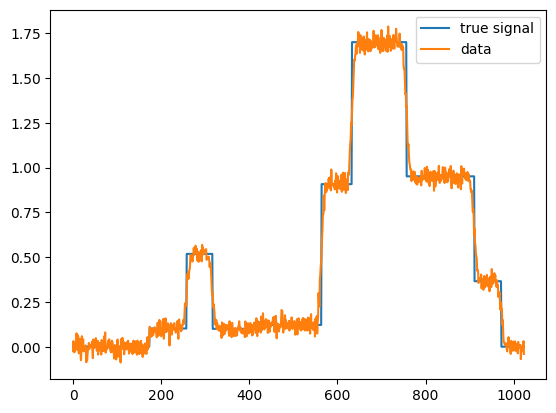

In [72]:
# plot signal and data
plt.figure()
plt.plot(x_true, label='true signal')
plt.plot(y, label='data')
plt.legend()
plt.show()

In [73]:
# rate parameters according to Besov^1_11 prior
delta_f = lambda l: 2**(1/2*l) # 2^(j* (s+d/2-d/p) ) where: j level (approx level scaled by 1),  d (dimension) = 1, p=s=1 
delta = np.zeros(d, dtype=np.double)
delta[coeff_slices[0]] = delta_f(0)
for ii in range(1, len(coeff_slices)):
    delta[coeff_slices[ii]['d']] = delta_f(ii)

In [74]:
# prior mean and covariance
pr_mean = np.zeros(d)
pr_cov = np.diag(2/delta**2)

In [75]:
## mean and covariance of Gaussian approximation at MAP ('Laplace approximation')

# find MAP
x = cp.Variable(d)
objective = cp.Minimize(lam/2* cp.sum_squares(y - A @ x) + cp.pnorm(cp.multiply(delta, x), 1))
problem = cp.Problem(objective)
result = problem.solve(verbose=1, max_iter=20000)
MAP_mean = x.value

# mean and covariance
eps_Hess = 4/np.max(delta)**2 # smoothing parameter (computed based on heuristic rule) for approximation of covariance
Hess = lam * A.T @ A + np.diag( delta*eps_Hess * 1/np.sqrt(MAP_mean**2 + eps_Hess)**3  ) # -\nabla^2\log\pi(x_MAP)
U, S, _ = np.linalg.svd(Hess, hermitian=1)
print(f'max abs error SVD: {np.max( np.abs( U@np.diag(S)@U.T - Hess ))}')
MAP_cov =  U@np.diag(1/S)@U.T

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Nov 11 04:00:03 PM: Your problem has 1024 variables, 0 constraints, and 0 parameters.
(CVXPY) Nov 11 04:00:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 11 04:00:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 11 04:00:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 11 04:00:03 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 11 04:00:03 PM: Compiling problem (target solver=OSQP).
(C

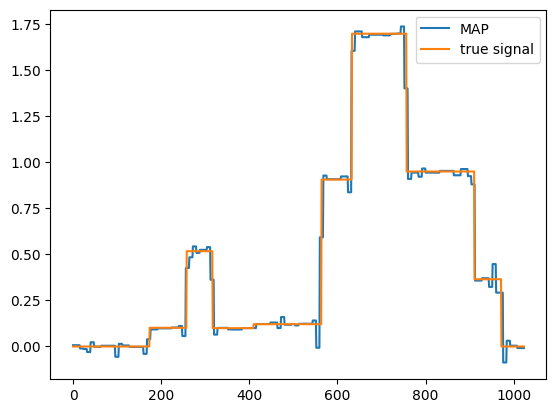

In [76]:
# plot MAP in signal space
plt.figure()
plt.plot(W(MAP_mean), label='MAP')
plt.plot(s_true, label='true signal')
plt.legend()

In [77]:
## diagnostic given estimates of posterior mean and covariance (-> CUQIpy?)

def diagnostic(A, y, rates, noise_prec, po_mean, po_cov):
    H = A.T@noise_prec@A
    d1 = np.sum( (H@po_cov).T * H, axis=0 ) # diagonal of H@po_cov@H    
    d2 = (A.T@(noise_prec@(y-A@po_mean)))**2
    return 1/rates**2 * (d1+d2) # = h

# estimate via prior
d_prior = diagnostic(A, y, delta, lam*np.eye(y.size), pr_mean, pr_cov)

# estimate via MAP
d_MAP = diagnostic(A, y, delta, lam*np.eye(y.size), MAP_mean, MAP_cov)

In [78]:
## prepare sampling of full posterior for reference samples

# scaling factor
s = delta

# prior
X = LaplaceSmoothed(location=torch.zeros(d, dtype=torch.double), scale=torch.from_numpy(1/s*1/delta), beta=beta)

# likelihood
A_torch = torch.from_numpy(A@np.diag(s))
noise_cov = (noise_std**2*torch.ones(A_torch.shape[0])).double()
Y = Gaussian(lambda X: torch.matmul(A_torch, X.double()), cov=noise_cov)

# posterior
X_Y = JointDistribution(X, Y)
p = X_Y(Y=y)

# sampler
torch.manual_seed(0)
nuts_sampler_ref = NUTS(p)

In [ ]:
# # sample full posterior
# samples_ref0 = nuts_sampler_ref.sample(N_po, N_b)
# # Sample: 100%|██████████| 11000/11000 [05:06, 35.92it/s, step size=1.46e-01, acc. prob=0.842]

# # save samples
# save(PurePath(os.getcwd(), 'ref_samples'), samples_ref0)

# load samples
samples_ref0 = load(PurePath(os.getcwd(), 'ref_samples'))

Sample: 100%|██████████| 11000/11000 [05:06, 35.92it/s, step size=1.46e-01, acc. prob=0.842]


Selecting 5 randomly chosen variables


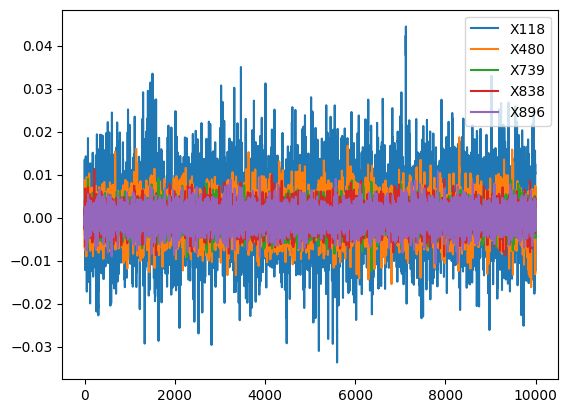

In [80]:
# check some traces
samples_ref0['X'].plot_chain()

In [81]:
# rescale and transform to signal space
np_samples_ref = np.diag(s) @ samples_ref0['X'].samples 
samples_ref = cuqi.samples.Samples(np_samples_ref)
samples_ref_signal = cuqi.samples.Samples(np.apply_along_axis(func1d=W, arr=np_samples_ref, axis=0))

In [ ]:
# # compute reference diagnostic
# log_like = lambda x: -lam * A.T@(y-A@x)
# d_ref = np.apply_along_axis(func1d=log_like, arr=np_samples_ref, axis=0)
# d_ref = 1/delta**2 * np.mean(d_ref**2, axis=1)
# save(PurePath(os.getcwd(), 'ref_diagnostic'), d_ref)

# load
d_ref = load(PurePath(os.getcwd(), 'ref_diagnostic'))

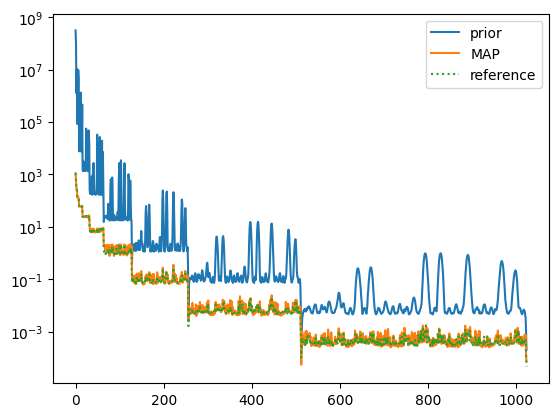

In [83]:
# plot diagnostics
plt.figure()
plt.semilogy(d_prior, label='prior')
plt.semilogy(d_MAP, label='MAP')
plt.semilogy(d_ref, label='reference', ls=':')
# plt.ylim([1e-4,1e10])
plt.legend()

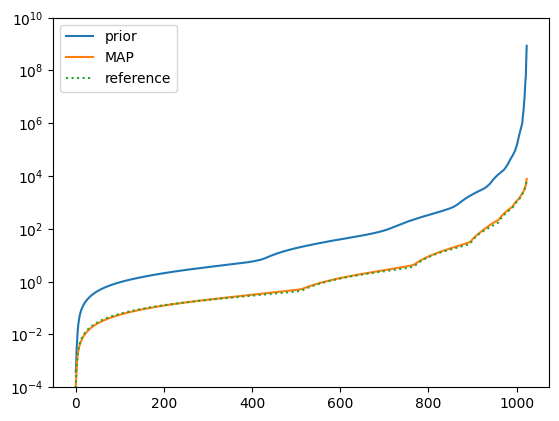

In [84]:
# plot upper bounds on Hellinger squared between exact and approx posterior
plt.figure()
plt.semilogy(2*np.cumsum(np.sort(d_prior)), label='prior')
plt.semilogy(2*np.cumsum(np.sort(d_MAP)), label='MAP')
plt.semilogy(2*np.cumsum(np.sort(d_ref)), label='reference', ls=':')
plt.ylim([1e-4,1e10])
plt.legend()

In [85]:
## reference posterior statistics

# mean
x_mean_ref = samples_ref.mean()
x_mean_ref_signal = samples_ref_signal.mean()

# CI
x_l_ref = samples_ref.compute_ci(CI)[0,:]
x_u_ref = samples_ref.compute_ci(CI)[1,:]
x_l_ref_signal = samples_ref_signal.compute_ci(CI)[0,:]
x_u_ref_signal = samples_ref_signal.compute_ci(CI)[1,:]

In [86]:
## prepare sampling of reduced posterior

# select coordinates via diagnostic obtained from prior 
I = np.argsort(d_prior)[-n_I:]
I_c = np.setdiff1d(np.arange(d), I)

# scaling factor
s = delta[I]

# prior
X = LaplaceSmoothed(location=torch.zeros(n_I, dtype=torch.double), scale=torch.from_numpy(1/s*1/delta[I]), beta=beta)

# likelihood
A_red = A[:,I]@np.diag(s)
A_red_torch = torch.from_numpy(A_red)
noise_cov = (noise_std**2*torch.ones(A_red_torch.shape[0])).double()
Y = Gaussian(lambda X: torch.matmul(A_red_torch, X.double()), cov=noise_cov)

# posterior
X_Y = JointDistribution(X, Y)
p = X_Y(Y=y)

# sampler
torch.manual_seed(1)
nuts_sampler = NUTS(p)

In [ ]:
# sample reduced posterior in selected coordinates
# samples0 = nuts_sampler.sample(N_po, N_b)
# Sample: 100%|██████████| 11000/11000 [01:26, 126.91it/s, step size=4.24e-01, acc. prob=0.845]

# save samples
# save(PurePath(os.getcwd(), 'red_samples'), samples0)

# load samples
samples0 = load(PurePath(os.getcwd(), 'red_samples'))

Sample: 100%|██████████| 11000/11000 [01:26, 126.91it/s, step size=4.24e-01, acc. prob=0.845]


Selecting 5 randomly chosen variables


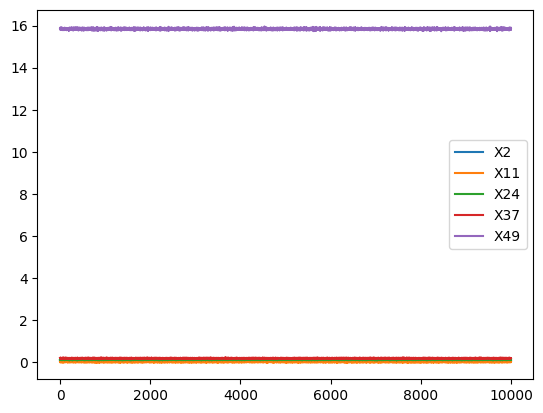

In [88]:
# check some traces
samples0['X'].plot_chain()

In [89]:
# sample not selected coordinates from prior 
np_samples = np.zeros((d, N_po))
np_samples[I_c] = fast_Laplace(delta[I_c], N_po)

# rescale samples from NUTS
np_samples[I] = np.diag(s)@samples0['X'].samples
samples = cuqi.samples.Samples(np_samples)

# transform to signal space
samples_signal = cuqi.samples.Samples(np.apply_along_axis(func1d=W, arr=np_samples, axis=0))

In [90]:
## reduced posterior statistics

# mean
x_mean = samples.mean()
x_mean_signal = samples_signal.mean()

# CI
x_l = samples.compute_ci(CI)[0,:]
x_u = samples.compute_ci(CI)[1,:]
x_l_signal = samples_signal.compute_ci(CI)[0,:]
x_u_signal = samples_signal.compute_ci(CI)[1,:]

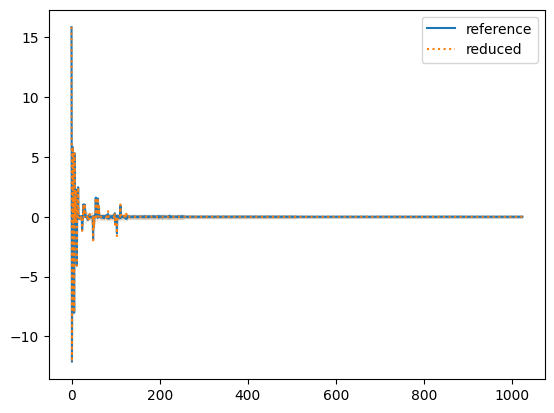

In [91]:
# plot statistics in coefficient space
plt.figure()
p = plt.plot(x_mean_ref, label='reference')
plt.fill_between(np.arange(d), x_u_ref, x_l_ref, color=p[-1].get_color(), alpha=0.3, lw=0)
p = plt.plot(x_mean, label='reduced', ls=':')
plt.fill_between(np.arange(d), x_u, x_l, color=p[-1].get_color(), alpha=0.3, lw=0)
# plt.xlim([0,10])
plt.legend()

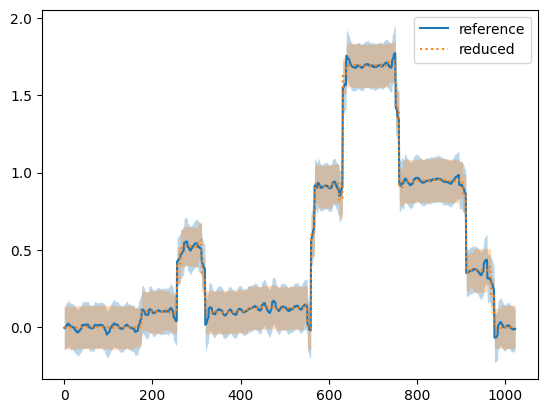

In [92]:
# plot statistics in signal space
plt.figure()
p = plt.plot(x_mean_ref_signal, label='reference')
plt.fill_between(np.arange(d), x_u_ref_signal, x_l_ref_signal, color=p[-1].get_color(), alpha=0.3, lw=0)
p = plt.plot(x_mean_signal, label='reduced', ls=':')
plt.fill_between(np.arange(d), x_u_signal, x_l_signal, color=p[-1].get_color(), alpha=0.3, lw=0)
# plt.xlim([0,10])
plt.legend()